# Payback Analysis

Project to analyze when an investment in solar power would pay itself considering the inflation and the basic Tax rate of Brazil (SELIC)

## Importing Libraries

In [1]:
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats

## Helper Functions

In [2]:
def get_break(total: float, pmt:float, i: float):

        """
        A function that gets the total periods, the periodic payments, and the tax rate, and returns the total periods until the payback and the present value of the investment (pmt)
        
        """
        count: float = 0
        n: int = 1
        while count < total:
            count += pmt/((1+i)**n)
            n += 1
            if n>50*12: break
        return n, round(count, 2)

In [3]:
def get_real_rate(inflation_rate: float, interest_rate: float):

    """
    A function the returns the real tax rate removing inflation
    """

    real_rate = (1+interest_rate)/(1+inflation_rate) - 1
    return real_rate

In [4]:

def get_break_random(
    limit: float, 
    pmt: float,  
    mean: float, 
    std: float, 
    total_simulations: int = 15_000, 
    variation: float = .5, 
    fixed_tx: bool = True):

    """
    A function that calculates the payback using random scenarios, based on the normal distribution
    """

    count = 1
    total = 0
    i = 1
    if fixed_tx:
        tx = np.random.normal(mean, std)/100
    while (total < limit and count < total_simulations):
        # print(total)
        # print(count)
        if not fixed_tx:
            tx = np.random.normal(mean, std)/100
        new_pmt = np.random.normal(pmt, pmt*variation)
        i = i * (1+tx)
        total = total + (new_pmt)/i
        count += 1
        # print(total, new_pmt, i, tx, )

    return count


## Reading the Selic and the Inflation data

This data will come from the official government historical SELIC and Inflation rates

In [5]:
last = 120
selic_address = f'https://api.bcb.gov.br/dados/serie/bcdata.sgs.4390/dados/ultimos/{last}?formato=csv'
ipca_address = f'https://api.bcb.gov.br/dados/serie/bcdata.sgs.10844/dados/ultimos/{last}?formato=csv'


### Data Wrangling

In [6]:
selic_historic = pd.read_csv(selic_address, delimiter=';')
ipca_historic = pd.read_csv(ipca_address, delimiter=';')
ipca_historic.valor  = ipca_historic.valor.str.replace(',', '.').apply(float)
selic_historic.valor = selic_historic.valor.str.replace(',', '.').apply(float)


In [7]:
historical_data = pd.merge(selic_historic, ipca_historic, right_on='data', left_on='data').rename(columns={'valor_x': 'selic', 'valor_y': 'ipca'})

#### Getting the real tax rate value – removing inflation effects

In [8]:
historical_data['real'] = ((historical_data.selic/100 + 1) / (historical_data.ipca/100 + 1) - 1)*100

## Getting statistical information from the real tax rate

In [9]:
historical_data.real.describe()

count    119.000000
mean       0.245440
std        0.375024
min       -0.799605
25%        0.054620
50%        0.277805
75%        0.483827
max        1.000500
Name: real, dtype: float64

### Plotting the histograms of SELIC, Inflation, and the real tax rate


          Data Selic Shapiro pvalue:       0.00022719182015862316
          IPCA Shapiro pvalue:             0.5827066898345947 
          Real Interets Shapiro pvalue:    0.13774077594280243 


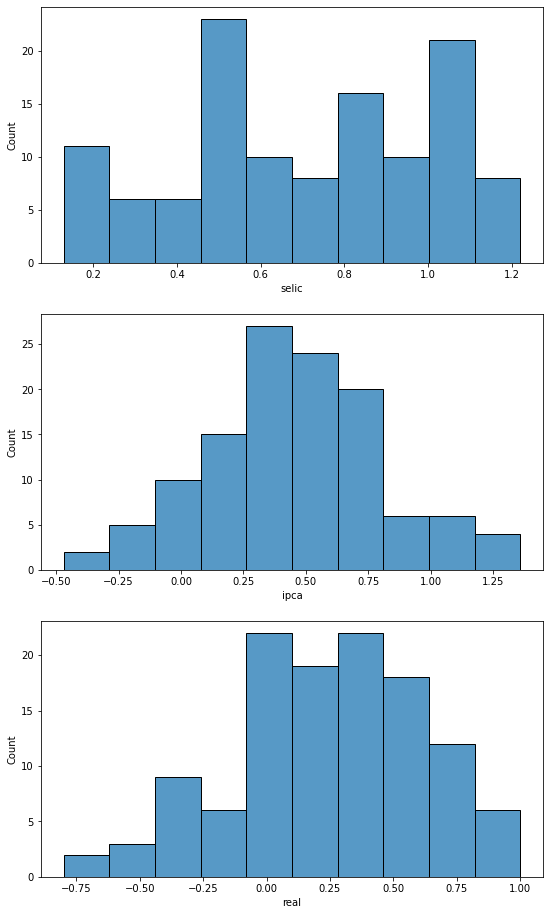

In [10]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(9,16))
sns.histplot(historical_data.selic, ax=ax1, bins=10)
sns.histplot(historical_data.ipca, ax=ax2, bins=10)
sns.histplot(historical_data.real, ax=ax3, bins=10)
print(f'''
          Data Selic Shapiro pvalue:       {stats.shapiro(historical_data.selic).pvalue}
          IPCA Shapiro pvalue:             {stats.shapiro(historical_data.ipca).pvalue} 
          Real Interets Shapiro pvalue:    {stats.shapiro(historical_data.real).pvalue} '''


)


### Pairplot of the variables

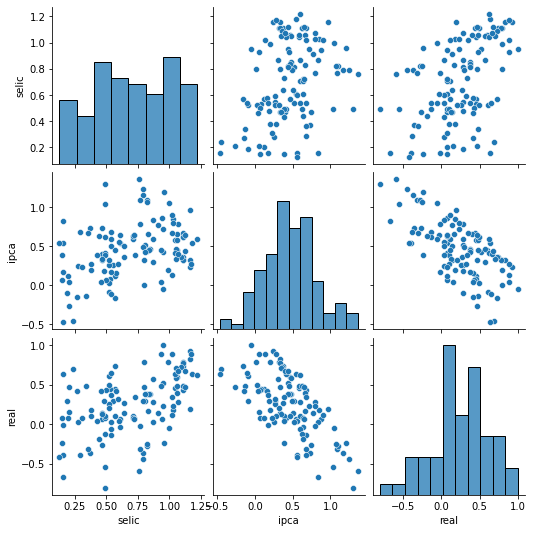

In [19]:
sns.pairplot(historical_data)

## Getting a sample from the past energy bill data

- Doing the shapiro-wilk test to see wether it is a normal distribution or not

In [11]:
measures = np.array([494,479,365,389,405,413,365,336,365,293,318,434,351,376,315,324,335,394,306,293,298,307,382,342,315,393,401,421,445,401,358,392,338,355,377,367,395,425,392,385,378,408,380,400,333,360,373,425,397,398,443,399,374,335,356,366,401,469,530])
stats.shapiro(measures)

ShapiroResult(statistic=0.9675702452659607, pvalue=0.11667385697364807)

<AxesSubplot:ylabel='Count'>

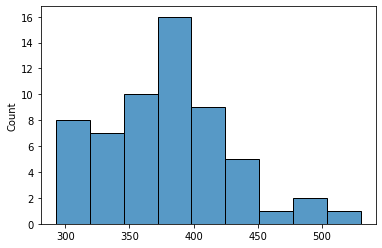

In [12]:
sns.histplot(measures)

In [13]:
print(np.std(measures))

variation = np.std(measures)/np.mean(measures)
variation

48.67199930381911


0.128404934668455

### Fixed tax

Using the same random real tax rate inside simulations

In [14]:
value_pmt = 450
# variation = 0.1443001443001443
value_install = 22_500
n_simulations = 15_000 
fixed_tx = True
total_simulations = 600

# def get_break_random(limit: float, pmt: float,  mean: float, std: float, total_simulations: int=15_000, variation: float = .5)
results = [get_break_random(limit=value_install, 
                            pmt=value_pmt, 
                            variation=variation, 
                            mean=historical_data.real.mean(),
                            std=historical_data.real.std(),
                            total_simulations=total_simulations,
                            fixed_tx=fixed_tx) for i in range(n_simulations)]
# results = [get_break(
#     value_install,
#     np.random.normal(value_pmt,(600-value_pmt)/3.08)*.6,
#     np.random.normal(historical_data.real.mean(), historical_data.real.std())/100)[0] for i in range(n_simulations)]
    # np.random.normal(historical_data.real.mean(), historical_data.real.std())/100)[0] for i in range(n_simulations)]
    # (((historical_data.selic.sample(1).values[0] + 1) /(historical_data.ipca.sample(1).values[0]+1)) - 1)/100) for i in range(n_simulations)]
    # historical_data.real.sample(1).values[0])[0] for i in range(n_simulations)]

print(f'''
min: {np.min(results)}
2.5%: {np.percentile(results, 2.5).round(2)}
median: {np.median(results)}
97.5%: {np.percentile(results, 97.5).round(2)}
max: {np.max(results)}

mean: {np.mean(results).round(2)}
std: {np.std(results).round(2)}
''')


min: 41
2.5%: 46.0
median: 55.0
97.5%: 71.0
max: 126

mean: 55.81
std: 6.53



(34.33543324275051, 77.29163342391635)

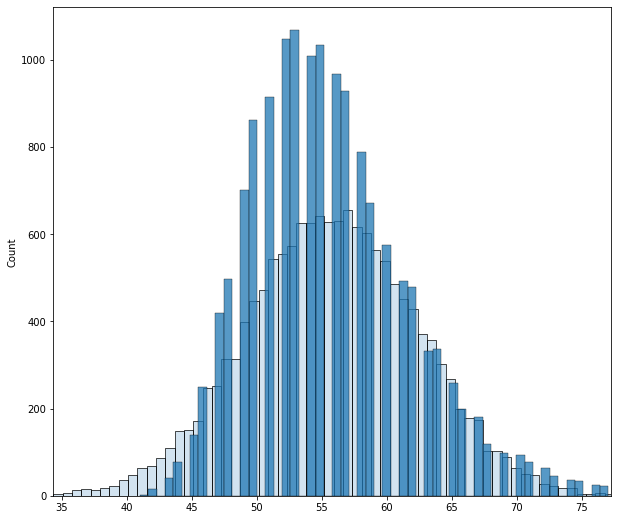

In [15]:
plt.figure(figsize=(10,9))
sns.histplot(np.random.normal(np.mean(results), np.std(results), n_simulations), alpha=.2)
sns.histplot(results)
plt.xlim(stats.norm.ppf(.0005, np.mean(results), np.std(results)),stats.norm.ppf(.9995, np.mean(results), np.std(results)))

### Random tax

Using a random tax rate for every iteration

In [16]:
value_pmt = 450
# variation = 0.1443001443001443
value_install = 22_500
n_simulations = 15_000 
fixed_tx = False
total_simulations = 600

# def get_break_random(limit: float, pmt: float,  mean: float, std: float, total_simulations: int=15_000, variation: float = .5)
results = [get_break_random(limit=value_install, 
                            pmt=value_pmt, 
                            variation=variation, 
                            mean=historical_data.real.mean(),
                            std=historical_data.real.std(),
                            total_simulations=total_simulations,
                            fixed_tx=fixed_tx) for i in range(n_simulations)]
# results = [get_break(
#     value_install,
#     np.random.normal(value_pmt,(600-value_pmt)/3.08)*.6,
#     np.random.normal(historical_data.real.mean(), historical_data.real.std())/100)[0] for i in range(n_simulations)]
    # np.random.normal(historical_data.real.mean(), historical_data.real.std())/100)[0] for i in range(n_simulations)]
    # (((historical_data.selic.sample(1).values[0] + 1) /(historical_data.ipca.sample(1).values[0]+1)) - 1)/100) for i in range(n_simulations)]
    # historical_data.real.sample(1).values[0])[0] for i in range(n_simulations)]

print(f'''
min: {np.min(results)}
2.5%: {np.percentile(results, 2.5).round(2)}
median: {np.median(results)}
97.5%: {np.percentile(results, 97.5).round(2)}
max: {np.max(results)}

mean: {np.mean(results).round(2)}
std: {np.std(results).round(2)}
''')


min: 50
2.5%: 52.0
median: 55.0
97.5%: 58.0
max: 60

mean: 54.91
std: 1.37



(50.408692924617974, 59.41717374204874)

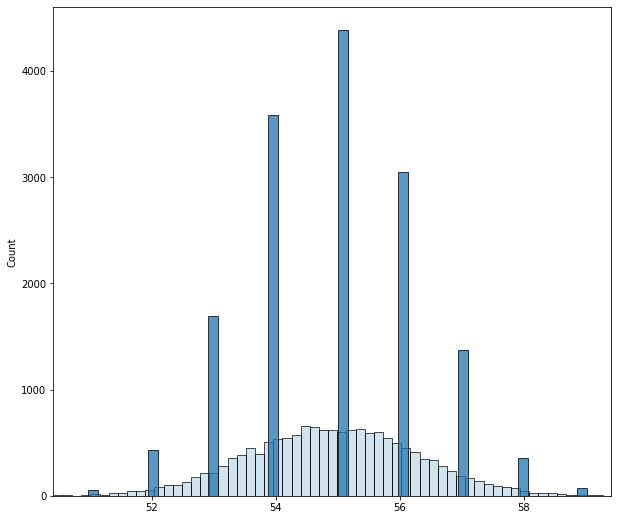

In [17]:
plt.figure(figsize=(10,9))
sns.histplot(np.random.normal(np.mean(results), np.std(results), n_simulations), alpha=.2)
sns.histplot(results)
plt.xlim(stats.norm.ppf(.0005, np.mean(results), np.std(results)),stats.norm.ppf(.9995, np.mean(results), np.std(results)))

## Comparing the bootstrap approach to the normal distribution approach

Checking if using a bootstrap approach we get closer to a normal distribution

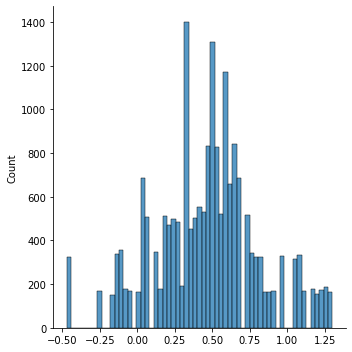

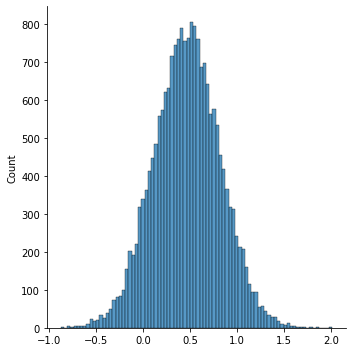

In [15]:
# plt.figure()
n_size = 20000
sns.displot(historical_data.ipca.sample(n_size, replace=True).values)
sns.displot(np.random.normal(historical_data.ipca.mean(), historical_data.ipca.std(), n_size))